## Solucion del proyecto: Vender 100 mil copias de un video juego
### Módulo 4 - Big Data
### Estudidante: Yoksan Varela Cambronero

### Primera parte: Carga del set de datos desde POSTGRESQL DB
A continuacion se hace una carga en limpio del set de datos almacenado en la base de datos. El nombre de la base de datos es *video_games_ml_ready*:

In [1]:
# Librerias generales
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Iniciando la sesion de Spark
import findspark # type: ignore
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Video Games Spark Session") \
    .config("spark.driver.extraClassPath", "postgresql-42.7.3.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.7.3.jar") \
    .getOrCreate()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/14 18:42:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
# Carga de la base de datos de POSTGRESQL
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "video_games_etl_completed") \
    .load()

df.printSchema()
df.show()

root
 |-- game_title: string (nullable = true)
 |-- console: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- genre: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- user_score: float (nullable = true)
 |-- total_sales: float (nullable = true)

+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|          game_title|console|           publisher|release_date|          genre|              rating|user_score|total_sales|
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|   super bust-a-move|    gba|             ubisoft|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.05|
|   super bust-a-move|    ps2|acclaim entertain...|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.34|
|                tmnt|     ds|             ubis

In [4]:
# Confirmando que no haya NaN or Nulls
from pyspark.sql.functions import col, sum

nan_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
nan_counts.show()

+----------+-------+---------+------------+-----+------+----------+-----------+
|game_title|console|publisher|release_date|genre|rating|user_score|total_sales|
+----------+-------+---------+------------+-----+------+----------+-----------+
|         0|      0|        0|           0|    0|     0|         0|          0|
+----------+-------+---------+------------+-----+------+----------+-----------+



In [5]:
num_rows = df.count()
num_columns = len(df.columns)
print(f"Dimensiones del dataframe: ({num_rows}, {num_columns})")

Dimensiones del dataframe: (8593, 8)


### Segunda parte: Objetivo predictivo y analisis estadistico del set de datos

Ya con el set de datos cargados, se procede a hacer una analisis preliminar de los datos para entender los atributos y su relacion con la variable de salida. De primera entrada, se empieza con la creacion del objetivo predictivo:

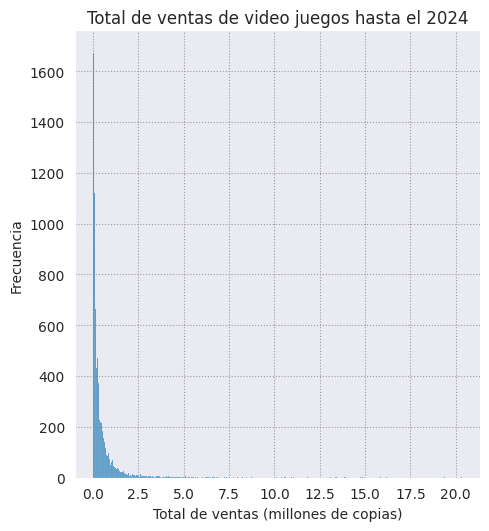

In [6]:
# Analizando el balanceo en el objetivo predictivo
# Estilo de Seaborn
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Hacer collect de la variable predictiva
df_vg_sales = df.select('total_sales').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_vg_sales, kde=False)
plt.xlabel('Total de ventas (millones de copias)')
plt.ylabel('Frecuencia')
plt.title('Total de ventas de video juegos hasta el 2024')
plt.show()

Hay una cantidad de juegos que se han vendido mucho, lo cual genera esa cola larga hacia la derecha. Haciendo un analisis mas enfocado cerca del punto de interes de las 100 mil copias vendidas:

In [7]:
# Filtrando el set de datos por los menos de un millon de copias vendidas
df_vg_sales_filtered = df.filter(df['total_sales'] < 1)
num_rows = df_vg_sales_filtered.count()
num_columns = len(df_vg_sales_filtered.columns)

# Imprimiendo informacion del set de datos filtrado
print(f"Dimensiones del dataframe: ({num_rows}, {num_columns})")
df_vg_sales_filtered.show()

Dimensiones del dataframe: (7514, 8)
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|          game_title|console|           publisher|release_date|          genre|              rating|user_score|total_sales|
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+
|   super bust-a-move|    gba|             ubisoft|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.05|
|   super bust-a-move|    ps2|acclaim entertain...|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.34|
|                tmnt|     ds|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.04|
|                tmnt|    psp|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.11|
|                tmnt|    wii|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e 

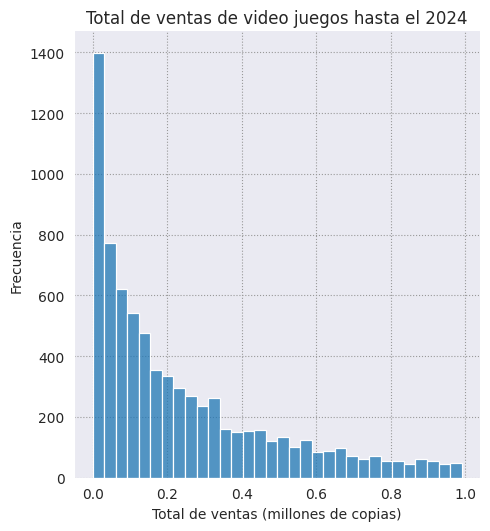

In [8]:
# Analizando mas cerca del punto de interes
df_vg_sales_less_1m = df_vg_sales_filtered.select('total_sales').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_vg_sales_less_1m, kde=False)
plt.xlabel('Total de ventas (millones de copias)')
plt.ylabel('Frecuencia')
plt.title('Total de ventas de video juegos hasta el 2024')
plt.show()

Las ventas totales siguen una distribucion lognormal. Ahora se crea un lable nuevo en donde la cantidad de ventas totales haya sido mayor a las 100 mil copias.

In [9]:
# Creando el label, siendo la variable predictiva
from pyspark.sql.functions import when

df_videogames_sales_target = df.withColumn("label", when(df["total_sales"] > 0.175, "Si").otherwise("No"))
df_videogames_sales_target.show()

+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+-----+
|          game_title|console|           publisher|release_date|          genre|              rating|user_score|total_sales|label|
+--------------------+-------+--------------------+------------+---------------+--------------------+----------+-----------+-----+
|   super bust-a-move|    gba|             ubisoft|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.05|   No|
|   super bust-a-move|    ps2|acclaim entertain...|  2000-11-26|matching puzzle|rated e for everyone|  6.894852|       0.34|   Si|
|                tmnt|     ds|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.04|   No|
|                tmnt|    psp|             ubisoft|  2007-03-20| 3d beat-'em-up|rated e +10 for e...|       5.9|       0.11|   No|
|                tmnt|    wii|             ubisoft|  2007-03-20| 3d beat-'em-up|rat

Dimensiones del dataframe: (8593, 9)


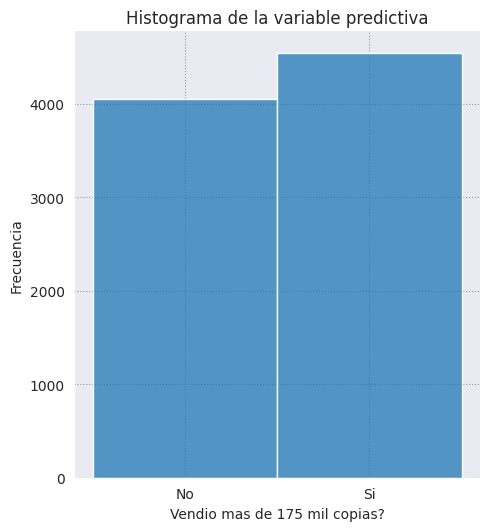

In [10]:
# Analizando el label
df_vg_sales_label = df_videogames_sales_target.select('label').rdd.flatMap(lambda x: x).collect()

# Algunas metricas del set de datos con el label de interes
num_rows = df_videogames_sales_target.count()
num_columns = len(df_videogames_sales_target.columns)
print(f"Dimensiones del dataframe: ({num_rows}, {num_columns})")

sns.displot(data=df_vg_sales_label, kde=False)
plt.xlabel('Vendio mas de 175 mil copias?')
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable predictiva')
plt.show()

In [11]:
# Contando el total de valores unicos en varias columnas
unique_publisher_count = df_videogames_sales_target.select("publisher").distinct().count()
unique_genre_count = df_videogames_sales_target.select("genre").distinct().count()
unique_console_count = df_videogames_sales_target.select("console").distinct().count()

print(f"Cantidad de valores unicos en publisher: {unique_publisher_count}")
print(f"Cantidad de valores unicos en genre: {unique_genre_count}")
print(f"Cantidad de valores unicos en console: {unique_console_count}")

Cantidad de valores unicos en publisher: 355
Cantidad de valores unicos en genre: 115
Cantidad de valores unicos en console: 33


No hay problema de balance con el objetivo predictivo. Se descartan las siguientes columnas a este punto:
- game_title: Este atributo es unico por juego, por lo tanto, no va a tener un peso a la hora de generalizar.
- release_date: No se tiene intencion de hacer un analisis temporal, ademas, ya es conocido que es mas facil vender juegos en tiempos festivos como navidad.
- total_sales: Ya con el objetivo predictivo creado a partir de esta columna, esta se vuelve innecesaria

In [12]:
df_videogames_sales_target = df_videogames_sales_target.drop('game_title', 'release_date', 'total_sales')

Analizando el atributo consolas:

Text(0.5, 1.0, 'Distribucion de las consolas con respecto al objetivo predictivo')

<Figure size 1000x600 with 0 Axes>

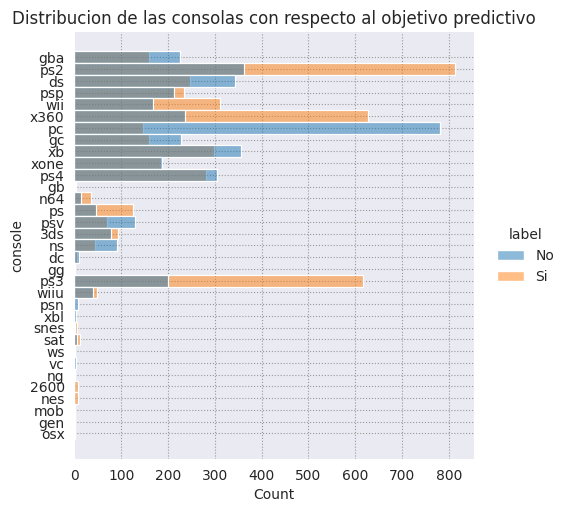

In [13]:
# Creando arreglos y diccionarios compatibles con algunas funciones de seaborn
consoles_data = df_videogames_sales_target.select('console', 'label').collect()

# Creando las listas
console_list = [row['console'] for row in consoles_data]
category_list = [row['label'] for row in consoles_data]

# Creando el diccionario
data_dict = {
    "console": console_list,
    "label": category_list
}

# Creando el plot
plt.figure(figsize=(10, 6))
sns.displot(data=data_dict, y="console", hue="label")
plt.title('Distribucion de las consolas con respecto al objetivo predictivo')

Hay muchas consolas que no tienen data representativa, pero se van a mantener en el estudio. Ademas, vale la pena resaltar que vender juegos en consolas como Wii, PlayStation 2, PlayStation 3 y XBox 360 han dado mas casos positivos, en cambio, vender en PC genera muchos casos en donde no se alcanza la meta.

Veamos ahora en genero de los juegos:

Text(0.5, 1.0, 'Distribucion de las consolas con respecto al objetivo predictivo')

<Figure size 1000x600 with 0 Axes>

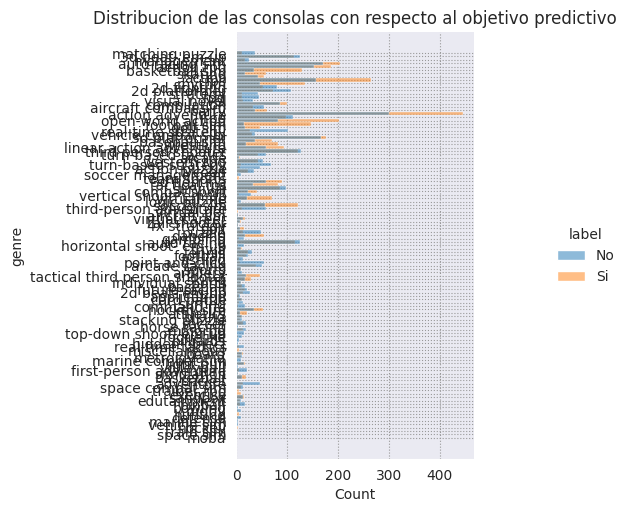

In [14]:
# Creando arreglos y diccionarios compatibles con algunas funciones de seaborn
genre_data = df_videogames_sales_target.select('genre', 'label').collect()

# Creando las listas
genre_list = [row['genre'] for row in genre_data]
category_list = [row['label'] for row in genre_data]

# Creando el diccionario
data_dict = {
    "genre": genre_list,
    "label": category_list
}

# Creando el plot
plt.figure(figsize=(10, 6))
sns.displot(data=data_dict, y="genre", hue="label")
plt.title('Distribucion de las consolas con respecto al objetivo predictivo')

Hay una cantidad muy grande de generos, lo cual hace que el grafico sea dificil de leer, pero nota una distribucion de datos saludable con respecto al objetivo predictivo. Este escenario es aun peor con los publisher, asi que no se hara un analisis visual de este atributo.

Analizando ahora el rating o clasificacion del juego y la calificacion por usuario:

Text(0.5, 1.0, 'Distribucion de las consolas con respecto al objetivo predictivo')

<Figure size 1000x600 with 0 Axes>

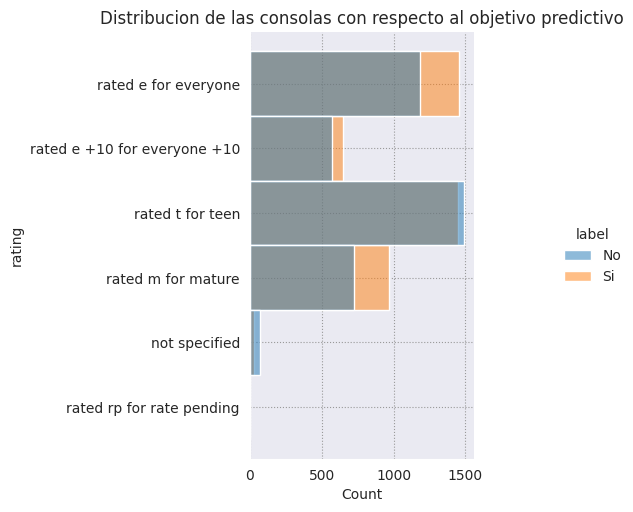

<Figure size 1000x600 with 0 Axes>

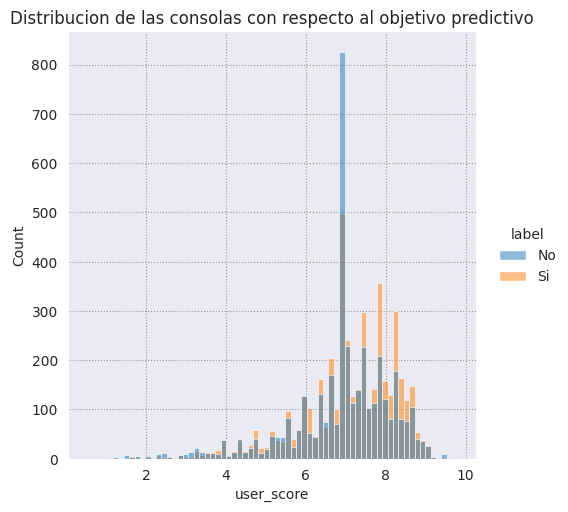

In [15]:
# Creando arreglos y diccionarios compatibles con algunas funciones de seaborn
more_data = df_videogames_sales_target.select('rating', 'user_score', 'label').collect()

# Creando las listas
rating_list = [row['rating'] for row in more_data]
user_score_list = [row['user_score'] for row in more_data]
category_list = [row['label'] for row in more_data]

# Creando el diccionario
data_dict = {
    "rating": rating_list,
    "user_score": user_score_list,
    "label": category_list
}

# Creando el plot para el rating
plt.figure(figsize=(10, 6))
sns.displot(data=data_dict, y="rating", hue="label")
plt.title('Distribucion de las consolas con respecto al objetivo predictivo')

# Creando el plot para el user_score
plt.figure(figsize=(10, 6))
sns.displot(data=data_dict, x="user_score", hue="label")
plt.title('Distribucion de las consolas con respecto al objetivo predictivo')

Con esto se concluye que el set de datos esta listo para el proceso de entrenamiento y prueba de soluciones de aprendizaje automatico. Se cuentan con mas de 500 categorias y mas de 8000 instancias, y con una variable predictiva balanceada.

In [16]:
df_videogames_sales_target.printSchema()
df_videogames_sales_target.show()

root
 |-- console: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- user_score: float (nullable = true)
 |-- label: string (nullable = false)

+-------+--------------------+---------------+--------------------+----------+-----+
|console|           publisher|          genre|              rating|user_score|label|
+-------+--------------------+---------------+--------------------+----------+-----+
|    gba|             ubisoft|matching puzzle|rated e for everyone|  6.894852|   No|
|    ps2|acclaim entertain...|matching puzzle|rated e for everyone|  6.894852|   Si|
|     ds|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|   No|
|    psp|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|   No|
|    wii|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|   Si|
|   x360|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|  

In [17]:
# Almacenando este dataframe final en la base de datos como video_games_ml_ready
df_videogames_sales_target \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "video_games_ml_ready") \
    .save()

### Tercera parte: Vectorizacion de los atributos y analisis de correlacion

Primero, se cargan los datos desde la base de datos:

In [18]:
# Carga de la base de datos de POSTGRESQL
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "video_games_ml_ready") \
    .load()

df.printSchema()
df.show()

root
 |-- console: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- user_score: float (nullable = true)
 |-- label: string (nullable = true)

+-------+--------------------+---------------+--------------------+----------+-----+
|console|           publisher|          genre|              rating|user_score|label|
+-------+--------------------+---------------+--------------------+----------+-----+
|    gba|             ubisoft|matching puzzle|rated e for everyone|  6.894852|   No|
|    ps2|acclaim entertain...|matching puzzle|rated e for everyone|  6.894852|   Si|
|     ds|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|   No|
|    psp|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|   No|
|    wii|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|   Si|
|   x360|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|   

In [19]:
# Cambiando el label por 1 y 0 en lugar de Si o No
df = df.withColumn('label', when(df['label'] == 'Si', '1').otherwise('0'))
df.show()

+-------+--------------------+---------------+--------------------+----------+-----+
|console|           publisher|          genre|              rating|user_score|label|
+-------+--------------------+---------------+--------------------+----------+-----+
|    gba|             ubisoft|matching puzzle|rated e for everyone|  6.894852|    0|
|    ps2|acclaim entertain...|matching puzzle|rated e for everyone|  6.894852|    1|
|     ds|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|    0|
|    psp|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|    0|
|    wii|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|    1|
|   x360|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|    1|
|     pc|       kalypso media|     management|    rated t for teen|       7.6|    0|
|     gc|            vu games|auto racing sim|rated e for everyone|  6.894852|    0|
|     xb|gathering of deve...|auto racing sim|rated e for everyon

In [20]:
# Indexado de los atributos categoricos
from pyspark.ml.feature import StringIndexer

indexer_console = StringIndexer(inputCol='console', outputCol='console_indexed')
df_indexed = indexer_console.fit(df).transform(df)

indexer_publisher = StringIndexer(inputCol='publisher', outputCol='publisher_indexed')
df_indexed = indexer_publisher.fit(df_indexed).transform(df_indexed)

indexer_genre = StringIndexer(inputCol='genre', outputCol='genre_indexed')
df_indexed = indexer_genre.fit(df_indexed).transform(df_indexed)

indexer_rating = StringIndexer(inputCol='rating', outputCol='rating_indexed')
df_indexed = indexer_rating.fit(df_indexed).transform(df_indexed)

df_indexed.show()

+-------+--------------------+---------------+--------------------+----------+-----+---------------+-----------------+-------------+--------------+
|console|           publisher|          genre|              rating|user_score|label|console_indexed|publisher_indexed|genre_indexed|rating_indexed|
+-------+--------------------+---------------+--------------------+----------+-----+---------------+-----------------+-------------+--------------+
|    gba|             ubisoft|matching puzzle|rated e for everyone|  6.894852|    0|            9.0|              0.0|         48.0|           1.0|
|    ps2|acclaim entertain...|matching puzzle|rated e for everyone|  6.894852|    1|            0.0|             23.0|         48.0|           1.0|
|     ds|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|    0|            5.0|              0.0|          8.0|           3.0|
|    psp|             ubisoft| 3d beat-'em-up|rated e +10 for e...|       5.9|    0|            8.0|            

In [21]:
# Haciendo un One Hot Encoding the las columnas indexadas
from pyspark.ml.feature import OneHotEncoder

encoder_console = OneHotEncoder(inputCol="console_indexed", outputCol="console_vector", dropLast = False)
df_encoded = encoder_console.fit(df_indexed).transform(df_indexed)

encoder_publisher = OneHotEncoder(inputCol="publisher_indexed", outputCol="publisher_vector", dropLast = False)
df_encoded = encoder_publisher.fit(df_encoded).transform(df_encoded)

encoder_genre = OneHotEncoder(inputCol="genre_indexed", outputCol="genre_vector", dropLast = False)
df_encoded = encoder_genre.fit(df_encoded).transform(df_encoded)

encoder_rating = OneHotEncoder(inputCol="rating_indexed", outputCol="rating_vector", dropLast = False)
df_encoded = encoder_rating.fit(df_encoded).transform(df_encoded)

df_encoded.show()

+-------+--------------------+---------------+--------------------+----------+-----+---------------+-----------------+-------------+--------------+---------------+-----------------+----------------+-------------+
|console|           publisher|          genre|              rating|user_score|label|console_indexed|publisher_indexed|genre_indexed|rating_indexed| console_vector| publisher_vector|    genre_vector|rating_vector|
+-------+--------------------+---------------+--------------------+----------+-----+---------------+-----------------+-------------+--------------+---------------+-----------------+----------------+-------------+
|    gba|             ubisoft|matching puzzle|rated e for everyone|  6.894852|    0|            9.0|              0.0|         48.0|           1.0| (33,[9],[1.0])|  (355,[0],[1.0])|(115,[48],[1.0])|(6,[1],[1.0])|
|    ps2|acclaim entertain...|matching puzzle|rated e for everyone|  6.894852|    1|            0.0|             23.0|         48.0|           1.0| 

In [22]:
# Ensamblando el vector de features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['console_vector', 
                                       'publisher_vector', 
                                       'genre_vector', 
                                       'rating_vector', 
                                       'user_score'], outputCol='features_not_scaled')
df_assembled = assembler.transform(df_encoded)
df_video_games_data = df_assembled.select('features_not_scaled', 'label')
df_video_games_data.show()

+--------------------+-----+
| features_not_scaled|label|
+--------------------+-----+
|(510,[9,33,436,50...|    0|
|(510,[0,56,436,50...|    1|
|(510,[5,33,396,50...|    0|
|(510,[8,33,396,50...|    0|
|(510,[7,33,396,50...|    1|
|(510,[2,33,396,50...|    1|
|(510,[1,93,439,50...|    0|
|(510,[10,75,390,5...|    0|
|(510,[4,109,390,5...|    1|
|(510,[0,133,392,5...|    1|
|(510,[11,34,403,5...|    0|
|(510,[6,34,403,50...|    1|
|(510,[24,35,421,5...|    1|
|(510,[17,35,421,5...|    1|
|(510,[14,35,421,5...|    1|
|(510,[6,262,413,5...|    0|
|(510,[6,58,392,50...|    0|
|(510,[12,58,392,5...|    1|
|(510,[4,42,389,50...|    0|
|(510,[0,42,389,50...|    1|
+--------------------+-----+
only showing top 20 rows



In [23]:
# Normalizando los atributos para tener todos los features en la misma escala
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_not_scaled", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_video_games_data)
df_video_games_data_normalized = scaler_model.transform(df_video_games_data)
df_video_games_data_normalized.show()

+--------------------+-----+--------------------+
| features_not_scaled|label|            features|
+--------------------+-----+--------------------+
|(510,[9,33,436,50...|    0|[-0.3983621788932...|
|(510,[0,56,436,50...|    1|[2.50998633701966...|
|(510,[5,33,396,50...|    0|[-0.3983621788932...|
|(510,[8,33,396,50...|    0|[-0.3983621788932...|
|(510,[7,33,396,50...|    1|[-0.3983621788932...|
|(510,[2,33,396,50...|    1|[-0.3983621788932...|
|(510,[1,93,439,50...|    0|[-0.3983621788932...|
|(510,[10,75,390,5...|    0|[-0.3983621788932...|
|(510,[4,109,390,5...|    1|[-0.3983621788932...|
|(510,[0,133,392,5...|    1|[2.50998633701966...|
|(510,[11,34,403,5...|    0|[-0.3983621788932...|
|(510,[6,34,403,50...|    1|[-0.3983621788932...|
|(510,[24,35,421,5...|    1|[-0.3983621788932...|
|(510,[17,35,421,5...|    1|[-0.3983621788932...|
|(510,[14,35,421,5...|    1|[-0.3983621788932...|
|(510,[6,262,413,5...|    0|[-0.3983621788932...|
|(510,[6,58,392,50...|    0|[-0.3983621788932...|


24/07/14 18:42:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


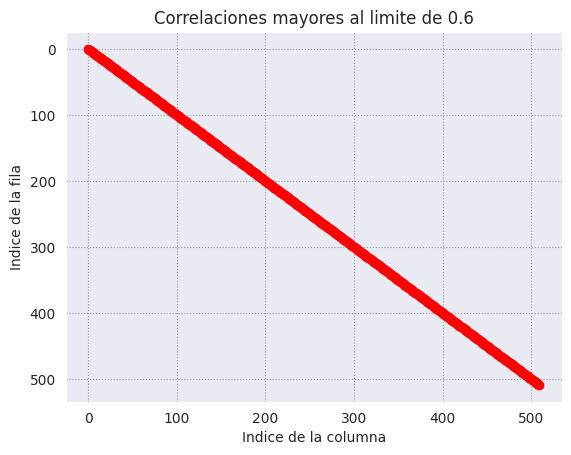

In [24]:
# Visualizando la correlacion de los atributos mas importantes
from pyspark.ml.stat import Correlation

# Creando una matriz de correlacion como arreglo
correlation_matrix = Correlation.corr(df_video_games_data_normalized, "features").head()[0].toArray()

# Definiendo el nivel de una correlacion importante
value = 0.6

# Extrayendo las coordenadas de cualquier correlacion mayor al limite
indices = np.where(correlation_matrix > value)
row_indices, col_indices = indices

# Graficando estas correlaciones importantes. Entre mas puntos rojos, peor.
# La diagonal va a aparecer por tener un valor de 1.
plt.scatter(col_indices, row_indices, color='red')
plt.gca().invert_yaxis()
plt.xlabel('Indice de la columna')
plt.ylabel('Indice de la fila')
plt.title(f'Correlaciones mayores al limite de {value}')
plt.grid(True)
plt.show()


Con esta grafica se confirma que no hay alguna correlacion importante que antender en el set de datos. Continuando con crear los sets de entremiento y prueba para los modelos.

### Cuarta parte: Entrenamiento y prueba de 2 modelos de aprendizaje automatico

In [25]:
# Convirtiendo la columna label a integer
df_vg_data = df_video_games_data_normalized.withColumn('label', col('label').cast("integer"))
df_vg_data = df_vg_data.select('features', 'label')
df_vg_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.3983621788932...|    0|
|[2.50998633701966...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[2.50998633701966...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[2.50998633701966...|    1|
+--------------------+-----+
only showing top 20 rows



In [26]:
# Antes de empezar con los modelos, se hace un split de 80/20 para prueba y entrenamiento
train_df, test_df = df_vg_data.randomSplit([0.8, 0.2], seed=202020)

print('Train dataset:')
train_df.show()
print('Test dataset:')
test_df.show()

Train dataset:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    0|
+--------------------+-----+
only showing top 20 rows

Test dataset:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.3983621788932...|    1|
|[-0.3983621788932...|    0|
|[-0.398362178893

### Primero Modelo: Decision Tree

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

dt_model = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [28]:
# Optimizador de hiperparametros
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt_model.maxDepth, [5, 10, 15]) \
    .addGrid(dt_model.maxBins, [20, 40, 60]) \
    .build()

# Protocolo k-fold de 5
evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
crossval_dt = CrossValidator(estimator=dt_model,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=evaluator_dt,
                          numFolds=5)

In [29]:
# Corriendo la validacion cruzada
dt_cvModel = crossval_dt.fit(train_df)

In [30]:
# Haciendo una prediccion y evaluando el Accuracy
dt_predictions = dt_cvModel.transform(test_df)

accuracy_dt = evaluator_dt.evaluate(dt_predictions)
print(f"Desicion Tree accuracy = {accuracy_dt}")

dt_predictions.show()

Desicion Tree accuracy = 0.7045324153757889
+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|[-0.3983621788932...|    0|[1174.0,501.0]|[0.70089552238805...|       0.0|
|[-0.3983621788932...|    1|[1174.0,501.0]|[0.70089552238805...|       0.0|
|[-0.3983621788932...|    0| [376.0,406.0]|[0.48081841432225...|       1.0|
|[-0.3983621788932...|    1| [376.0,406.0]|[0.48081841432225...|       1.0|
|[-0.3983621788932...|    0|     [3.0,0.0]|           [1.0,0.0]|       0.0|
|[-0.3983621788932...|    1|    [0.0,80.0]|           [0.0,1.0]|       1.0|
|[-0.3983621788932...|    1|  [18.0,140.0]|[0.11392405063291...|       1.0|
|[-0.3983621788932...|    1|[1174.0,501.0]|[0.70089552238805...|       0.0|
|[-0.3983621788932...|    0| [376.0,406.0]|[0.48081841432225...|       1.0|
|[-0.3983621788932...|    1|[1174.0,501.0]|[

### Segundo Modelo: Random Forest

In [31]:
# Creando el modelo Random Forest
from pyspark.ml.classification import RandomForestClassifier

rf_model = RandomForestClassifier(featuresCol='features', labelCol='label')

In [32]:
# Optimizador de hiperparametros
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [5, 10 , 15, 20]) \
    .addGrid(rf_model.maxDepth, [2, 5, 10, 15]) \
    .build()

# Protocolo k-fold de 5
evaluator_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
crossval_rf = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=evaluator_rf,
                          numFolds=5)

In [33]:
# Corriendo la validacion cruzada
rf_cvModel = crossval_rf.fit(train_df)

In [34]:
# Haciendo una prediccion y evaluando el Accuracy
rf_predictions = rf_cvModel.transform(test_df)

accuracy_rf = evaluator_rf.evaluate(rf_predictions)
print(f"Random Forest accuracy = {accuracy_rf}")

rf_predictions.show()

Random Forest accuracy = 0.7131382673551349
+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-0.3983621788932...|    0|[9.81227940243465...|[0.65415196016231...|       0.0|
|[-0.3983621788932...|    1|[7.42032991295445...|[0.49468866086363...|       1.0|
|[-0.3983621788932...|    0|[7.14786266115308...|[0.47652417741020...|       1.0|
|[-0.3983621788932...|    1|[7.25402039515380...|[0.48360135967692...|       1.0|
|[-0.3983621788932...|    0|[5.88584758835721...|[0.39238983922381...|       1.0|
|[-0.3983621788932...|    1|[5.19495790787074...|[0.34633052719138...|       1.0|
|[-0.3983621788932...|    1|[6.98975077611647...|[0.46598338507443...|       1.0|
|[-0.3983621788932...|    1|[7.77184509353702...|[0.51812300623580...|       0.0|
|[-0.3983621788932...|    0|[8.11560835942301...|[0.54

### Tercer Modelo: SVM

In [35]:
from pyspark.ml.classification import LinearSVC

svm_model = LinearSVC(featuresCol='features', labelCol='label')

In [36]:
# Optimizador de hiperparametros
paramGrid_svm = ParamGridBuilder() \
    .addGrid(svm_model.maxIter, [10, 20]) \
    .addGrid(svm_model.regParam, [0.1, 0.01]) \
    .build()

# Protocolo k-fold de 5
evaluator_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
crossval_svm = CrossValidator(estimator=svm_model,
                          estimatorParamMaps=paramGrid_svm,
                          evaluator=evaluator_svm,
                          numFolds=5)

In [37]:
# Corriendo la validacion cruzada
svm_cvModel = crossval_svm.fit(train_df)

In [38]:
# Haciendo una prediccion y evaluando el Accuracy
svm_predictions = svm_cvModel.transform(test_df)

accuracy_svm = evaluator_svm.evaluate(svm_predictions)
print(f"SVM accuracy = {accuracy_svm}")

svm_predictions.show()

SVM accuracy = 0.7492828456683879
+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[-0.3983621788932...|    0|[1.27215468313923...|       0.0|
|[-0.3983621788932...|    1|[-1.8279207406893...|       1.0|
|[-0.3983621788932...|    0|[-2.6236066075983...|       1.0|
|[-0.3983621788932...|    1|[-2.8934646912302...|       1.0|
|[-0.3983621788932...|    0|[1.60632032023569...|       0.0|
|[-0.3983621788932...|    1|[-0.8364628222800...|       1.0|
|[-0.3983621788932...|    1|[-0.4056749836053...|       1.0|
|[-0.3983621788932...|    1|[-2.3758474627564...|       1.0|
|[-0.3983621788932...|    0|[-2.2884151280742...|       1.0|
|[-0.3983621788932...|    1|[1.08028607261812...|       0.0|
|[-0.3983621788932...|    1|[-0.8611048218579...|       1.0|
|[-0.3983621788932...|    1|[1.21771189497351...|       0.0|
|[-0.3983621788932...|    1|[0.56346389876172...|  